<a href="https://colab.research.google.com/github/jennahgosciak/nyc_fire_risk/blob/main/00_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

root= r"C:/Users/Jennah/Desktop/Code/nyc_fire_risk"

# Estimating Fire Casualties in NYC
In NYC, recent fires--like the fire that occurred recently in the Bronx, in which 17 people died--have been devasting. It is important for cities to develop better tools for understanding where such catastrophic events might occur and target these areas for better prevention measures. Specifically, while a building may receive numerous violations from the New York City Housing and Preservation Department (HPD), HPD in turn may not know which buildings to target and when such violations are serious.

I propose a predictive model that calculates the risk of a __catastrophic__ fire using variables not considered in other models.

* I incorporate water and electricity use, as a measure of crowding in the building.
* I use data on past violations in the building, as a measure of a negligent landlord.
* Data on median household income in the surrounding area.
* Population density in the surrounding area.
* Average daily temperature.
* Number of residential building units and building FAR.

# Load data on fire dispatch events
## From January 1st, 2017 through the present
* Create a plot of fire events each year
* Only structural fires are included


In [2]:
# load data on all fire dispate events for structural fires
url_fire_ev = 'https://data.cityofnewyork.us/resource/8m42-w767.csv?$limit=1000000&$where=INCIDENT_CLASSIFICATION_GROUP="Structural%20Fires"'
fire_ev = pd.read_csv(url_fire_ev)
print(fire_ev.shape)

# if false, then we might not have downloaded all data
print(fire_ev.shape[0])
assert fire_ev.shape[0] < 1000000

(456376, 29)
456376


In [3]:
# create month, date, and year variables
fire_ev["incident_date"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.date
fire_ev["incident_month"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.month
fire_ev["incident_day"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.day
fire_ev["incident_year"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.year

fire_ev["incident_md"]= fire_ev[["incident_month", "incident_day"]].astype(str).apply('-'.join, 1)
print("\nFire events by year")
fire_ev["incident_year"].value_counts().sort_index()


Fire events by year


2005    31247
2006    30546
2007    30651
2008    29163
2009    28753
2010    28961
2011    27595
2012    27908
2013    25097
2014    26531
2015    27403
2016    27442
2017    28259
2018    27119
2019    26154
2020    25035
2021     8512
Name: incident_year, dtype: int64

In [4]:
fire_ev.head()

,starfire_incident_id,incident_datetime,alarm_box_borough,alarm_box_number,alarm_box_location,incident_borough,zipcode,policeprecinct,citycouncildistrict,communitydistrict,...,incident_response_seconds_qy,incident_travel_tm_seconds_qy,engines_assigned_quantity,ladders_assigned_quantity,other_units_assigned_quantity,incident_date,incident_month,incident_day,incident_year,incident_md
0,5.001924e+14,2005-01-01T00:07:32.000,QUEENS,9237,N/SVC RD H. HARDING EXPY & 99 ST,QUEENS,11368.0,110.0,21.0,404.0,...,338,236,3,2,2,2005-01-01,1,1,2005,1-1
1,5.001149e+14,2005-01-01T00:14:40.000,MANHATTAN,1493,BWAY & W125 ST\M.L.KING JR BLVD,MANHATTAN,10027.0,26.0,7.0,109.0,...,266,217,2,2,1,2005-01-01,1,1,2005,1-1
2,5.001088e+14,2005-01-01T00:16:29.000,MANHATTAN,878,2 AVE & 53 ST,MANHATTAN,10022.0,17.0,4.0,106.0,...,298,220,5,4,6,2005-01-01,1,1,2005,1-1
3,5.001088e+14,2005-01-01T00:16:29.000,MANHATTAN,878,2 AVE & 53 ST,MANHATTAN,10022.0,17.0,4.0,106.0,...,298,220,5,4,6,2005-01-01,1,1,2005,1-1
4,5.001065e+14,2005-01-01T00:24:58.000,BROOKLYN,653,LAFAYETTE & CLASSON AVES,BROOKLYN,11238.0,79.0,35.0,303.0,...,226,189,3,2,1,2005-01-01,1,1,2005,1-1


## More fire events occur in late November, December, and early January

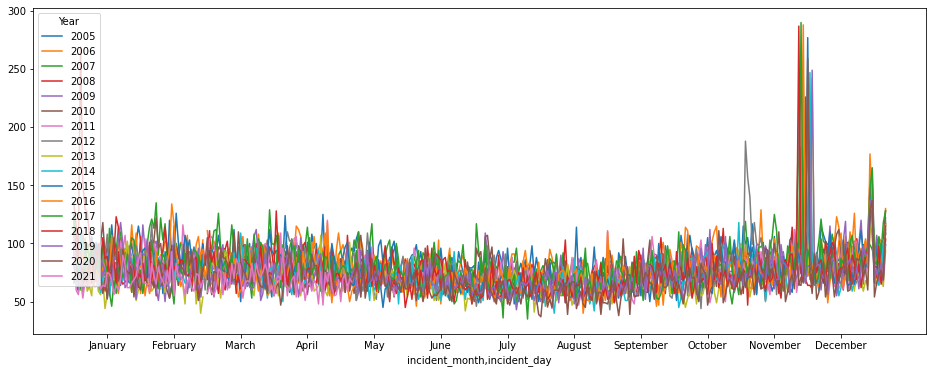

In [5]:
# plot dispatch events over time
# group by month year, day (count)
# make year the first level (pivot level)
fire_ev_plt_df= fire_ev.groupby(["incident_year", "incident_month", "incident_day"]).size().unstack(level = 'incident_year')
fire_ev_plt_df.columns.name= "Year"

fig, ax = plt.subplots(figsize=(13, 6))
fire_ev_plt_df.plot(ax = ax)

# set for month labels
x = [(x, 15) for x in list(range(1,13))]

# create ticks for each month (in the middle, with labels)
plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x != ''])
fig.set_size_inches(16, 6)
plt.savefig(os.join(root, "figs/fire_ev_line.pdf"))

# Load data on vacate orders from HPD, due to fire
## From January 1st, 2017 through the present

* Order to repair/vacate orders: https://data.cityofnewyork.us/resource/tb8q-a3ar
* Fire Department building vacate list: https://data.cityofnewyork.us/resource/n5xc-7jfa
* Future work: combine old and new vacate orders? First dataset only has 93 records

In [6]:
url_vac_old = 'https://data.cityofnewyork.us/resource/n5xc-7jfa.csv?$limit=1000000'
vac_old = pd.read_csv(url_vac_old)
print("Size of data:", vac_old.shape)
# format date variable
vac_old["vac_date_orig"]= vac_old["vac_date"].copy()
vac_old["vac_date"]= pd.to_datetime(vac_old["vac_date"]).dt.date
vac_old["vac_year"]= pd.to_datetime(vac_old["vac_date"]).dt.year
# sort data
vac_old.sort_values("vac_year", ascending = True).head()

Size of data: (93, 19)


,vac_date,num,pf,location_1,typ,sf,bor,date_of_lif,area_vac,div,...,latitude,longitude,community_board,community_council,census_tract,bin,bbl,nta,vac_date_orig,vac_year
0,2008-05-19,1234,NaN,INTERVALE,AVE,NaN,BX,NaN,ENTIRE BLDG,6,...,40.828940,-73.894516,3.0,17.0,125.0,2010459.0,2.029740e+09,Morrisania-Melrose ...,5/19/2008,2008
1,2008-05-31,1556,NaN,PARKER,ST,NaN,BX,NaN,BASEMENT,6,...,40.838231,-73.850162,10.0,18.0,202.0,2041683.0,2.039720e+09,Westchester-Unionport ...,5/31/2008,2008
2,2009-03-17,1420,NaN,CROTONA,AVE,NaN,BX,NaN,ENTIRE BUILDING,6,...,40.834290,-73.898082,3.0,16.0,151.0,2009823.0,2.029370e+09,Morrisania-Melrose ...,3/17/2009,2009
3,2009-07-03,414,E,140,ST,NaN,BX,NaN,3rd floor and one room 2nd floor,6,...,40.810042,-73.921112,1.0,8.0,39.0,2000289.0,2.022840e+09,Mott Haven-Port Morris ...,7/3/2009,2009
13,2010-12-09,1443,NaN,TAYLOR,AVE,NaN,BX,NaN,BASEMENT FRONT,7,...,40.836275,-73.866172,9.0,18.0,218.0,2028224.0,2.038990e+09,West Farms-Bronx River ...,12/9/2010,2010


In [7]:
# load vacate orders
url_vac = 'https://data.cityofnewyork.us/resource/tb8q-a3ar.csv?$limit=1000000&$where=primary_vacate_reason="Fire%20Damage"'
vac = pd.read_csv(url_vac)
print(vac.shape)

# if false, then we might not have downloaded all data
print(vac.shape[0])
assert vac.shape[0] < 1000000

(2890, 20)
2890


In [8]:
# create date, month, and year variables
vac["vacate_effective_date2"]= pd.to_datetime(vac["vacate_effective_date"]).dt.date
vac["vacate_effective_month"]= pd.to_datetime(vac["vacate_effective_date"]).dt.month
vac["vacate_effective_day"]= pd.to_datetime(vac["vacate_effective_date"]).dt.day
vac["vacate_effective_year"]= pd.to_datetime(vac["vacate_effective_date"]).dt.year

vac["vacate_effective_md"]= vac[["vacate_effective_month", "vacate_effective_day"]].astype(str).apply('-'.join, 1)

In [9]:
# number of fires per year
vac["vacate_effective_year"].value_counts().sort_index()

2012    283
2013    299
2014    250
2015    253
2016    241
2017    311
2018    312
2019    296
2020    274
2021    314
2022     57
Name: vacate_effective_year, dtype: int64

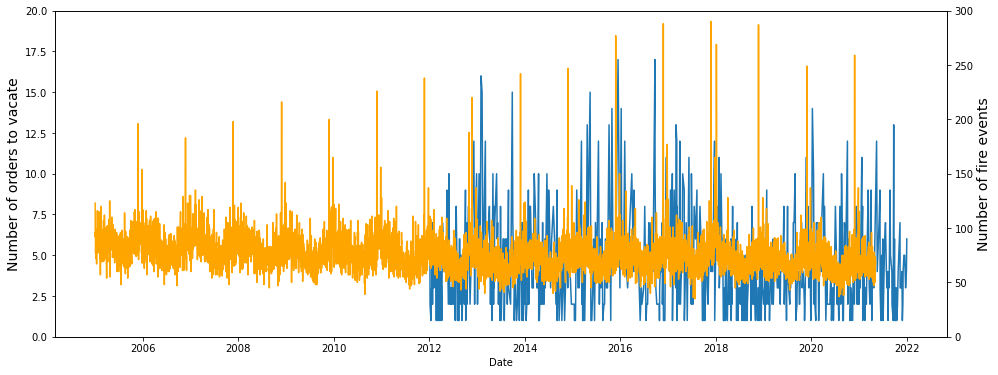

In [10]:
# create plots over time
fig, ax = plt.subplots(figsize=(13, 6))
vac.loc[vac["vacate_effective_year"] < 2022, :].groupby("vacate_effective_date2").size().plot(ax = ax)
ax.set_ylabel("Number of orders to vacate", fontsize=14)
ax.set_ylim([0, 20])

# set second axis
ax2=ax.twinx()
fire_ev.groupby("incident_date").size().plot(ax = ax2, color = "orange")
ax2.set_ylabel("Number of fire events", fontsize=14)
ax2.set_ylim([0, 300])

ax.set_xlabel("Date")
fig.set_size_inches(16, 6)
plt.savefig(os.join(root, "figs/vac_line.pdf"))

In [ ]:
## load pluto
pluto= gpd.read_file(os.join(root, "data/nyc_mappluto_21v4_shp/MapPLUTO.shp"))
usecols = ["borough", "bbl", "cd", "ct2010", "zipcode", "address", "bldgclass", "landuse", "ownertype", "ownername",
           "lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland", "assesstot",\
           "exempttot", "yearbuilt", "yearalter1", "yearalter2", "sanborn"]
pluto_df= pd.read_csv(os.join(root, "data/nyc_pluto_21v4_csv/pluto_21v4.csv"),
                      usecols = usecols)
pluto_df.head()

In [ ]:
# merge to pluto
vac_pluto= pluto.merge(vac, how = "inner", right_on = "bbl", left_on = "BBL")
vac_pluto.head()

In [ ]:
# left join from pluto to capture all properties
# use df for space constraints
vac_pluto_df= pluto_df.merge(vac, how = "left", right_on = "bbl", left_on = "bbl", indicator = True)
print(vac_pluto_df["_merge"].value_counts())

# create indicator of fire vacancy based on indicator
vac_pluto_df["vacate_ind"]= np.where(
            vac_pluto_df["_merge"]=="both", 1, 0)

print("\nTab of outcome var (vacate ind)")
print(vac_pluto_df[["vacate_ind", "_merge"]].value_counts())
vac_pluto_df.drop("_merge", axis = 1, inplace = True)

In [ ]:
# load boros for background
# plot spatially
boros= gpd.read_file('https://data.cityofnewyork.us/resource/7t3b-ywvw.geojson').set_crs(4326).to_crs(2263)
fig,ax = plt.subplots(figsize=(15,10))

vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

In [ ]:
# convert to point data
vac_pluto["geometry"]= vac_pluto["geometry"].representative_point()
fig,ax = plt.subplots(figsize=(15,10))
vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

### Create heat map of fire vacate orders

In [ ]:
# weight all the same
vac_pluto["weight"]= 1
# get extent
axis= boros.to_crs(4326).total_bounds
axis

# Calculate the kernel density estimate using gaussian kernels for heat map
# create x,y pairs of long,lat
# heatmaps are used when you have point data that can cluster;
# can see a concentration/elevated levels of events
data = np.c_[vac_pluto.longitude, vac_pluto.latitude]
# weights are all 1, apply kde to data
kde = scipy.stats.gaussian_kde(data.T, bw_method="scott", weights=vac_pluto.weight)

# Compute std along axis
data_std = data.std(axis=0, ddof=1)
# coefficient that multiplies the data covariance matrix to obtain the kernel covariance matrix
bw_x = getattr(kde, "scotts_factor")() * data_std[0]
bw_y = getattr(kde, "scotts_factor")() * data_std[1]
grid_x = grid_y = 100

# create support
x_support = seaborn.utils._kde_support(data[:, 0], bw_x, grid_x, 3, (axis[0], axis[2]))
y_support = seaborn.utils._kde_support(data[:, 1], bw_y, grid_y, 3, (axis[1], axis[3]))
xx, yy = np.meshgrid(x_support, y_support)
# reshape array
# extract values for grid
levels = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

# create map for the area w boros
ax = boros.to_crs(4326).plot(facecolor = 'none', edgecolor = 'gray',
                            figsize = (10, 10), alpha = 1)
# create levels
cset = ax.contourf(xx, yy, levels,
    100,
    cmap=seaborn.palettes.blend_palette(('#ffffff10', '#ff0000af'), 100, as_cmap=True),
    antialiased=True,
    alpha = 0.8
)
# hide lowest 4 levels
for i in range(0,5):
    cset.collections[i].set_alpha(0)
    
# remove lines on contour map
for c in cset.collections:
    c.set_edgecolor("face")
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()
plt.savefig(os.join(root, "figs/heatmap.pdf"), dpi=300, bbox_inches='tight')

# Load census data
* Plot median household income by census tract
* Will load additional variables
* From this [report](): “overcrowded” is more than one person per room, on average, and “severely overcrowded” is more than 1.5 persons per room.
    * Calculate overcrowing based on percentage > 1 person per room
    * Create an indicator using the citywide average

In [ ]:
# import census api
c = Census(config.api_key, year=2019)

# store census info in a dictionary
d = {}
           
for count in ['061', '085', '081', '047', '005']:
    # create temp for each county
    # all variables in list
    # store in dict
    temp= c.acs5.get(('NAME', 'B19013_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E',\
                                 'B25014_011E', 'B25014_012E', 'B25014_013E'),\
              {'for': 'tract:*', 'in': 'state:{} county:{}'.format(states.NY.fips, count)})
    
    d.update({(i["county"] + i["tract"]):i for i in temp})
d

In [ ]:
# create med hh inc df, pull variables for crowding
# create census df, rename cols using dict comprehension
oldcols= ['B19013_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E',\
                                 'B25014_011E', 'B25014_012E', 'B25014_013E']
newcols= ["medhhinc", "occ_total", "gt1_oo", "gt1_5_oo", "gt2_oo", "gt1_ro", "gt1_5_ro", "gt2_ro"]
census= pd.DataFrame.from_dict(d, orient = "index").rename({i:j for i,j in zip(oldcols, newcols)}, axis = 1).reset_index()\
            .rename({"index":"GEOID"}, axis = 1)

# load tract spatial data
tracts= gpd.read_file("https://data.cityofnewyork.us/resource/i69b-3rdj.geojson?$limit=100000")
# recode geoid var for merging
tracts["GEOID"]= np.select(
     [tracts['boro_code'] == "5", tracts['boro_code'] == "1", tracts['boro_code'] == "4",
      tracts['boro_code'] == "3", tracts['boro_code'] == "2"],
    ["085"+tracts["ct2010"], "061"+tracts["ct2010"], "081"+tracts["ct2010"], "047"+tracts["ct2010"],
    "005"+tracts["ct2010"]])

# check no missingness introduced
assert (tracts["GEOID"].isna() == tracts["boro_code"].isna()).all()
print(tracts["GEOID"].unique())
census

In [ ]:
# merge tracts to census data
tracts_census= tracts.merge(census, how = "outer", on = "GEOID")
tracts_census

# recode neg. values to missing
tracts_census['Median HH Inc']= np.where(
     tracts_census['medhhinc'] < 0, np.nan,
    tracts_census['medhhinc'])

# check recoding
assert (tracts_census["Median HH Inc"].isna() == (tracts_census['medhhinc'].isna() | (tracts_census['medhhinc'] < 0))).all()

In [ ]:
# create indicator for overcrowding variabel
tracts_census["sum_crowding"]= tracts_census[["gt1_oo", "gt1_5_oo", "gt2_oo", "gt1_ro", "gt1_5_ro", "gt2_ro"]].sum(axis = 1)
tracts_census["per_crowding"]= tracts_census.loc[:, "sum_crowding"].div(tracts_census.loc[:, "occ_total"]).fillna(0)

tracts_census["crowding_ind"]= np.where(
            tracts_census["per_crowding"]>=tracts_census["per_crowding"].mean(), 1, 0)
print("NYC Average from 2014-2019 ACS:", tracts_census["per_crowding"].mean())
print("\nCrosstab variable construction:")
print(tracts_census[["sum_crowding", "occ_total", "per_crowding"]].value_counts().sample(frac=0.025))
print("\nCheck indicator construction:")
print(tracts_census[["crowding_ind", "per_crowding"]].sample(frac=0.025).value_counts())

In [ ]:
# plot median household income by census tract
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.plot(column= "Median HH Inc", cmap = "YlOrBr", ax = ax, legend=True)
plt.title("Median household income, ACS 5-year 2019")
ax.axis('off')
plt.show()

In [ ]:
# plot percent crowding
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.plot(column= "per_crowding", cmap = "YlOrBr", ax = ax, legend = True)
plt.title("Percent Crowding, ACS 5-year 2019")
ax.axis('off')

In [ ]:
print(tracts_census.loc[tracts_census["per_crowding"] > 0.7, ["occ_total", "gt1_ro", "gt1_oo"]])
# outlier is small total number of properties
assert (tracts_census.loc[tracts_census["per_crowding"] > 0.7, "occ_total"].values == 5)

In [ ]:
# plot percent crowding, drop outlier for better visualization
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.loc[tracts_census["per_crowding"] <= 0.7, :]\
            .plot(column= "per_crowding", cmap = "YlOrBr", ax = ax, legend = True)
plt.title("Percent Crowding, ACS 5-year 2019")
ax.axis('off')

In [ ]:
# create county variable
vac_pluto_df["county"]= np.select(
     [vac_pluto_df['borough'] == "SI",
      vac_pluto_df['borough'] == "MN",
      vac_pluto_df['borough'] == "QN",
      vac_pluto_df['borough'] == "BK",
      vac_pluto_df['borough'] == "BX"],
    ["085", "061", "081", "047", "005"])
print("\nCheck coding of county from borough:")
print(vac_pluto_df[["county", "borough"]].value_counts())
assert (vac_pluto_df["county"].isna() == vac_pluto_df["borough"].isna()).all()

# create geoid variable
vac_pluto_df["GEOID"]= vac_pluto_df["county"] + vac_pluto_df["ct2010"].apply(lambda x: "%.2f" % x)\
                            .str.replace(".", "", regex = False)\
                            .str.pad(width = 6, side = "left", fillchar = "0")
vac_pluto_df["GEOID"]= np.where(
        vac_pluto_df["ct2010"].isna(), np.nan, vac_pluto_df["GEOID"])
print("\nCheck coding of GEOID from county and ct2010:")
print(vac_pluto_df[["GEOID", "county", "ct2010"]].sample(frac=0.05).value_counts())
assert (vac_pluto_df["GEOID"].isna() == vac_pluto_df["ct2010"].isna()).all()

# check per missing census tract
print("\nPercent missing census tract:", vac_pluto_df["ct2010"].isna().mean())

In [ ]:
vac_census= vac_pluto_df.merge(tracts_census.drop("geometry", axis = 1), how = "outer", on = "GEOID", indicator = True,\
                              validate= "many_to_one")
print("Check merge")
print(vac_census["_merge"].value_counts())
# make sure the three cases are missing median hhinc (no pop there)
assert vac_census.loc[vac_census["_merge"]=="right_only", "Median HH Inc"].isna().all()

In [ ]:
print("Unmerged values are evenly distributed; random checking suggests that these don't have census data associated w/ them")
print("We could geocode addresses to improve accuracy")
print(vac_census.loc[vac_census["_merge"]=="left_only", "borough"].value_counts())
vac_census.drop("_merge", axis = 1, inplace = True)

In [ ]:
print("Unmerged values are evenly distributed; random checking suggests that these don't have census data associated w/ them")
print("We could geocode addresses to improve accuracy")
print(vac_census.loc[vac_census["_merge"]=="left_only", "borough"].value_counts())
vac_census.drop(vac_census.loc[vac_census["_merge"]=="right_only"].index, inplace= True)
vac_census.drop("_merge", axis = 1, inplace = True)

In [ ]:
# check there are no missing bbl values
assert vac_census["bbl"].isna().sum() == 0

## Load data on electricity and water usage
* [2020 data](https://data.cityofnewyork.us/resource/usc3-8zwd.csv)
* [2019 data](https://data.cityofnewyork.us/resource/wcm8-aq5w.csv)
* [2018 data](https://data.cityofnewyork.us/resource/4tys-3tzj.csv)
* [2017 data](https://data.cityofnewyork.us/resource/4t62-jm4m.csv)

In [ ]:
# store urls
url_2020= "https://data.cityofnewyork.us/resource/usc3-8zwd.csv?$limit=100000"
url_2019= "https://data.cityofnewyork.us/resource/wcm8-aq5w.csv?$limit=100000"
url_2018= "https://data.cityofnewyork.us/resource/4tys-3tzj.csv?$limit=100000"
url_2017= "https://data.cityofnewyork.us/resource/4t62-jm4m.csv?$limit=100000"

# load and append data from each year
urls= [url_2017, url_2018, url_2019, url_2020]
cols= [["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot_bbl",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources_kgal", "multifamily_housing_number_of_bedrooms",\
                                        "multifamily_housing_total_number_of_residential_living_units"]]
# read in all data files using lc, combine across the rows
dfs= [pd.read_csv(urls[i], usecols = cols[i]) for i in range(0, 4)]
dfs

In [ ]:
# make names of columns uniform
dfs[0].columns = cols[0]
dfs[1].columns = cols[0]
dfs[2].columns = cols[0]
dfs[3].columns = cols[0]

# concatenate along rows (i.e. append data from each year)
df_ew= pd.concat(dfs, axis = 0)
df_ew

In [ ]:
# text formatting of bbl
df_ew.loc[:, "bbl"]= df_ew.iloc[:, 3].str.replace("[A-z]{1}[0-9]{3}-", "", regex = True)
df_ew.loc[:, "bbl"]= df_ew.loc[:, "bbl"].str.replace("-", "").str.replace(" ", ";")\
                        .str.replace("(?<=[0-9]{10})/", ";", regex = True)\
                        .str.replace("/", "")\
                        .str.replace(",", ";")\
                        .str.replace(":", ";")\
                        .str.replace("and", ";")\
                        .str.replace("&", ";")\
                        .str.replace("NotAvailable", "")\
                        .str.replace("multiple", "")
df_ew.loc[:, "bbl"]

In [ ]:
# need to split bbl into several columns
max_num= int(df_ew["bbl"].str.count(";").max())
df_ew[["bbl" + str(i) for i in range(0, (max_num + 1))]]= df_ew["bbl"].str.split(pat= ";", n=-1, expand = True)
df_ew[["bbl" + str(i) for i in range(0, (max_num + 1))]].head()

In [ ]:
# reshape and reformat bbl column
# pivot data long using melt
cols = [x for x in df_ew.columns if x not in ["bbl" + str(i) for i in range(0, max_num)] + ["bbl"]]
cols

# melt pivots data long
df_ewlong= pd.melt(df_ew.drop("bbl", axis = 1), id_vars=cols,var_name='bbl_num', value_name='bbl')
# recode comparison
print(df_ewlong[["bbl", "nyc_borough_block_and_lot"]].dropna().loc[(df_ewlong["bbl"].dropna()).map(len) > 10, :])

df_ewlong= df_ewlong[(df_ewlong["bbl"].notna()) | (df_ewlong["bbl"].isna() & \
                                                         df_ewlong["bbl_num"] == "bbl0")].drop_duplicates()

In [ ]:
# drop these values, not useful
df_ewlong= df_ewlong.drop(df_ewlong.loc[(df_ewlong["bbl"].str.len() != 10) | \
                (df_ewlong["bbl"] == "Code9Code9") | \
                (df_ewlong["bbl"] == "Not Available") | \
                (df_ewlong["bbl"] == "XXXXXXXXXX"), :].index, axis = 0)

In [ ]:
# clean total housing units data
df_ewlong.loc[(df_ewlong["multifamily_housing_total"] == "0") | \
              (df_ewlong["multifamily_housing_total"] == "Not Available"), "multifamily_housing_total"]= ""
df_ewlong["multifamily_housing_total_orig"]= df_ewlong["multifamily_housing_total"].copy()
df_ewlong["multifamily_housing_total"]= pd.to_numeric(df_ewlong["multifamily_housing_total"])

df_ewlong[["multifamily_housing_total", "multifamily_housing_total_orig"]].sample(frac=0.05).value_counts()

In [ ]:
# calculate water usage per unit (can also be calculated for comparison using resunits from pluto)
df_ewlong["water_num"]= pd.to_numeric(df_ewlong["water_use_all_water_sources"].str.replace("Not Available", ""))
# fill missing values with 0s
df_ewlong["pwater_num"]= df_ewlong["water_num"].div(df_ewlong["multifamily_housing_total"].astype(float), \
                                                       fill_value = 0).fillna(0)

In [ ]:
# merge to pluto and main df
print(df_ewlong[["bbl","pwater_num", "water_num", "multifamily_housing_total"]].head())
# need to convert bbl to string
vac_census["bbl"]= vac_census["bbl"].astype(str).str.replace(".0", "", regex = False)
assert (vac_census["bbl"].str.len() == 10).all()
assert (df_ewlong["bbl"].str.len() == 10).all()

vac_ew= pd.merge(vac_census, df_ewlong, how = "left", on = "bbl", indicator = True)

In [ ]:
print(vac_ew.shape)
# check size of unmerged buildings (small buildings under 10,000 sq. ft. for gov't buildings
# and 25,000 shouldn't be merging)
print(vac_ew.loc[vac_ew["property_id"].notna(), :].shape)
print(vac_ew.loc[vac_ew["property_id"].isna(), :].shape)
print(vac_ew.loc[(vac_ew["property_id"].isna()) & \
                       (vac_ew["bldgarea"] < 25000), "bldgarea"].shape)

print("\nMerge rate:")
print(vac_ew["_merge"].value_counts())
# assert there are no values unmerged on rhs
assert vac_ew.loc[vac_ew["_merge"]=="right_only"].shape[0]==0
vac_ew.drop("_merge", axis = 1, inplace = True)

## Load HPD Housing Code Violations
* Data saved on the [NYC Open Data Portal](https://data.cityofnewyork.us/resource/wvxf-dwi5.csv)
* Load Class C Violations (Class C are most severely hazardous)
* All violation filings since January 1st, 2017

In [ ]:
import psycopg2 as psy
# load furman db
connection = psy.connect(
    host="fcdata.c7h93yqbqnvu.us-east-1.rds.amazonaws.com",
    port=5432,
    user = "furmandata",
    password = config.furman_pwd,
    database = "fcdata")
cursor = connection.cursor()

In [ ]:
viol_summary= pd.read_sql("""SELECT violation_class, bbl, Count(*) FROM hpd_violations
                            WHERE inspection_date >= '2017-01-01'
                            GROUP BY violation_class, bbl;""", con=connection)
viol_summary= viol_summary.drop(viol_summary[(viol_summary["bbl"]=='0         ') | \
                                             (viol_summary["bbl"].isna())].index, axis = 0)
assert (viol_summary["bbl"].str.len() == 10).all()
viol_summary.head()

In [ ]:
# convert bbl to string
viol_summary["bbl"]= viol_summary["bbl"].astype(str).str.replace(".0", "", regex = False)
viol_summary= viol_summary.rename({"count":"num_viol"}, axis = 1)

In [ ]:
# pivot data wider
viol_wide= viol_summary.pivot(index='bbl', columns='violation_class', values = 'num_viol').fillna(0).reset_index()
viol_wide.head()

In [ ]:
# check length of bbl prior to merging
assert (vac_ew["bbl"].str.len() == 10).all()
assert (viol_wide["bbl"].str.len() == 10).all()
vac_viol= pd.merge(vac_ew, viol_wide, how = "left", on = "bbl", indicator = True)
print("Merge rate:")
print(vac_viol["_merge"].value_counts())
vac_viol.drop("_merge", axis = 1, inplace = True)

In [ ]:
print("Average number of class C violations:", vac_viol["C"].mean())
print("Average number of class C violations (among buildings w fire vacate orders):", \
      vac_viol.loc[vac_viol["vacate_ind"] == 1, "C"].mean())

# replace na values with 0
viol_cols= ["A", "B", "C", "I"]
vac_viol.loc[:, viol_cols]= vac_viol.loc[:, viol_cols].fillna(0)
# rename cols
vac_viol.rename({i:j for i,j in zip(viol_cols, ["numviol_" + x for x in viol_cols])}, axis = 1, inplace = True)
vac_viol.loc[:, ["numviol_" + x for x in ["A", "B", "C", "I"]]]

## Save cleaned analytic file
* Create version of data file with only selected variables that can be used for the analysis

In [ ]:
vac_viol["pwater_num_na"]= np.where(
    vac_viol["pwater_num"].isna() | np.isinf(vac_viol["pwater_num"]) | vac_viol["pwater_num"] == 0, 1, 0)
vac_viol["pwater_num"]= np.where(
    vac_viol["pwater_num"].isna() | np.isinf(vac_viol["pwater_num"]), 0, vac_viol["pwater_num"])
print(vac_viol[["pwater_num_na", "pwater_num"]].value_counts())

analysis_vars= ["bbl", "unitsres", "yearbuilt", "medhhinc", "assessland",\
                    "crowding_ind", "pwater_num", "pwater_num_na", "exempttot", "numviol_C", "vacate_ind"]
print(vac_viol.columns)
df_analysis= vac_viol.loc[:, analysis_vars]

In [ ]:
# export
df_analysis.to_csv(os.join(root, "data/analysis_file.csv"))